<a href="https://colab.research.google.com/github/Aditya-Shandilya1182/RUL_prediction/blob/main/project_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
TRAIN_FILE = "/kaggle/input/nasa-cmaps/CMaps/train_FD001.txt"
TEST_FILE  = "/kaggle/input/nasa-cmaps/CMaps/test_FD001.txt"
TEST_RUL_FILE = "/kaggle/input/nasa-cmaps/CMaps/RUL_FD001.txt"

COLUMNS_TO_REMOVE = ['rows', 'op_setting_3', 'sensor_1', 'sensor_5', 'sensor_6',
                     'sensor_10', 'sensor_16', 'sensor_19', 'sensor_18']

CLIP_RUL = None
SMOOTH_ROLLING = 0
WINDOW_SIZE = 30
STEP = 1
CLASS_THRESHOLD = 50

def make_column_names():
    cols = ['engine_number', 'time_in_cycles']
    cols += [f'op_setting_{i}' for i in range(1, 4)]
    cols += [f'sensor_{i}' for i in range(1, 22)]
    return cols

def load_cmapss(train_path, test_path, test_rul_path):
    train = pd.read_csv(train_path, delim_whitespace=True, header=None)
    test  = pd.read_csv(test_path, delim_whitespace=True, header=None)
    test_rul = pd.read_csv(test_rul_path, delim_whitespace=True, header=None)

    cols = make_column_names()
    train.columns = cols
    test.columns  = cols

    tr = test_rul.copy().reset_index(drop=True)
    tr.columns = ['RUL_final']
    tr['engine_number'] = np.arange(1, len(tr) + 1)

    return train, test, tr

def drop_unused(df, cols_to_remove=COLUMNS_TO_REMOVE):
    return df.drop(columns=[c for c in cols_to_remove if c in df.columns], errors='ignore')

def apply_rolling(df, window):
    if window and window > 1:
        ids = df[['engine_number', 'time_in_cycles']].copy()
        numeric = df.drop(columns=['engine_number', 'time_in_cycles'])
        rolled = numeric.groupby(df['engine_number']).apply(
            lambda g: g.rolling(window, min_periods=1).mean()
        ).reset_index(drop=True)
        return pd.concat([ids.reset_index(drop=True), rolled], axis=1)
    return df

def compute_train_rul(train_df):
    train = train_df.copy()
    train['time_in_cycles'] = pd.to_numeric(train['time_in_cycles'], errors='coerce')
    max_cycles = train.groupby('engine_number')['time_in_cycles'].max().reset_index()
    max_cycles.columns = ['engine_number', 'max_time_in_cycles']
    train = train.merge(max_cycles, on='engine_number', how='left')
    train['RUL'] = train['max_time_in_cycles'] - train['time_in_cycles']
    train.drop(columns=['max_time_in_cycles'], inplace=True)
    return train

def compute_test_rul(test_df, test_rul_df):
    test = test_df.copy()
    test['time_in_cycles'] = pd.to_numeric(test['time_in_cycles'], errors='coerce')
    max_cycles = test.groupby('engine_number')['time_in_cycles'].max().reset_index()
    max_cycles.columns = ['engine_number', 'max_time_in_cycles']
    test = test.merge(max_cycles, on='engine_number', how='left')

    tr = test_rul_df.copy()
    test = test.merge(tr, on='engine_number', how='left')
    test['RUL'] = test['RUL_final'] + (test['max_time_in_cycles'] - test['time_in_cycles'])
    test.drop(columns=['max_time_in_cycles', 'RUL_final'], inplace=True)
    return test

def normalize(train_df, test_df, feature_cols=None):
    if feature_cols is None:
        feature_cols = train_df.columns.tolist()[3:]
    scaler = MinMaxScaler()
    train = train_df.copy()
    test  = test_df.copy()
    train[feature_cols] = train[feature_cols].apply(pd.to_numeric, errors='coerce')
    test[feature_cols]  = test[feature_cols].apply(pd.to_numeric, errors='coerce')
    train[feature_cols] = scaler.fit_transform(train[feature_cols])
    test[feature_cols]  = scaler.transform(test[feature_cols])
    return train, test, scaler

def create_time_windows(df, feature_cols, target_col='RUL', window_size=30, step=1,
                        last_only=False, classification_threshold=None):
    X, y, engine_ids = [], [], []

    for engine in df['engine_number'].unique():
        eng_df = df[df['engine_number'] == engine].reset_index(drop=True)
        n = len(eng_df)
        if n < window_size:
            continue

        if last_only:
            starts = [n - window_size]
        else:
            starts = range(0, n - window_size + 1, step)

        for s in starts:
            e = s + window_size
            X.append(eng_df.loc[s:e-1, feature_cols].values)

            target = eng_df.loc[e-1, target_col]
            if classification_threshold is not None:
                target = 1 if target > classification_threshold else 0

            y.append(target)
            engine_ids.append(engine)

    if len(X) == 0:
        return np.empty((0, window_size, len(feature_cols))), np.array([]), np.array([])

    return np.array(X), np.array(y), np.array(engine_ids)



def preprocess_cmapss(train_path=TRAIN_FILE, test_path=TEST_FILE, test_rul_path=TEST_RUL_FILE,
                      drop_cols=COLUMNS_TO_REMOVE, smooth_window=SMOOTH_ROLLING,
                      clip_rul=CLIP_RUL, window_size=WINDOW_SIZE, step=STEP,
                      class_threshold=CLASS_THRESHOLD, normalize_rul=True):

    train, test, test_rul = load_cmapss(train_path, test_path, test_rul_path)

    train = drop_unused(train, drop_cols)
    test  = drop_unused(test, drop_cols)

    if smooth_window and smooth_window > 1:
        train = apply_rolling(train, smooth_window)
        test  = apply_rolling(test, smooth_window)

    train = compute_train_rul(train)
    test  = compute_test_rul(test, test_rul)

    non_features = ['engine_number', 'time_in_cycles', 'RUL']
    feature_cols = [c for c in train.columns if c not in non_features]

    train_norm, test_norm, scaler = normalize(train, test, feature_cols)

    if normalize_rul:
        max_rul = train_norm['RUL'].max()
        train_norm['RUL_scaled'] = train_norm['RUL'] / max_rul
        test_norm['RUL_scaled'] = test_norm['RUL'] / max_rul
        target_col = 'RUL_scaled'
    else:
        target_col = 'RUL'
    train_norm['label'] = train_norm['RUL'].apply(lambda x: 1 if x > class_threshold else 0)
    test_norm['label']  = test_norm['RUL'].apply(lambda x: 1 if x > class_threshold else 0)

    X_train, y_train, _ = create_time_windows(train_norm, feature_cols, target_col, window_size, step)
    X_test_last, y_test_last, _ = create_time_windows(test_norm, feature_cols, target_col, window_size, step, last_only=True)

    return {
        'train_df': train_norm,
        'test_df': test_norm,
        'feature_cols': feature_cols,
        'scaler': scaler,
        'X_train': X_train,
        'y_train': y_train,
        'X_test_last': X_test_last,
        'y_test_last': y_test_last,
        'max_rul': max_rul if normalize_rul else None
    }


data = preprocess_cmapss()

print("X_train shape:", data['X_train'].shape)
print("y_train shape:", data['y_train'].shape)
print("X_test_last shape:", data['X_test_last'].shape)
print("y_test_last shape:", data['y_test_last'].shape)



/tmp/ipykernel_47/2717413255.py:21: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train = pd.read_csv(train_path, delim_whitespace=True, header=None)
/tmp/ipykernel_47/2717413255.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test  = pd.read_csv(test_path, delim_whitespace=True, header=None)
/tmp/ipykernel_47/2717413255.py:23: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test_rul = pd.read_csv(test_rul_path, delim_whitespace=True, header=None)


X_train shape: (17731, 30, 16)
y_train shape: (17731,)
X_test_last shape: (100, 30, 16)
y_test_last shape: (100,)


In [ ]:
INPUT_SIZE = data['X_train'].shape[2]
HIDDEN_SIZE = 128
NUM_LAYERS = 2
BATCH_SIZE = 64
EPOCHS = 50
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
X_train = torch.tensor(data['X_train'], dtype=torch.float32)
y_train = torch.tensor(data['y_train'], dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(data['X_test_last'], dtype=torch.float32)
y_test = torch.tensor(data['y_test_last'], dtype=torch.float32).unsqueeze(1)

In [ ]:
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
class LSTM_Model(nn.Module):
    def __init__(self, input_size, hidden_size=128, dropout=0.2, fc_size=64):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                             num_layers=1, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)

        self.lstm2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size,
                             num_layers=1, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)

        self.fc1 = nn.Linear(hidden_size, fc_size)
        self.fc2 = nn.Linear(fc_size, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out = torch.tanh(out)
        out = self.dropout1(out)

        out, _ = self.lstm2(out)
        out = torch.tanh(out)
        out = self.dropout2(out)

        out = out[:, -1, :]

        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [ ]:
class GRU_Model(nn.Module):
    def __init__(self, input_size, hidden_size=128, dropout=0.2, fc_size=64):
        super().__init__()
        self.gru1 = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                           num_layers=1, batch_first=True)
        self.dropout1 = nn.Dropout(dropout)

        self.gru2 = nn.GRU(input_size=hidden_size, hidden_size=hidden_size,
                           num_layers=1, batch_first=True)
        self.dropout2 = nn.Dropout(dropout)

        self.fc1 = nn.Linear(hidden_size, fc_size)
        self.fc2 = nn.Linear(fc_size, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        out, _ = self.gru1(x)
        out = torch.tanh(out)
        out = self.dropout1(out)

        out, _ = self.gru2(out)
        out = torch.tanh(out)
        out = self.dropout2(out)

        out = out[:, -1, :]

        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out


In [ ]:
class RNN_Model(nn.Module):
    def __init__(self, input_size, hidden_size=128, dropout=0.2, fc_size=64):
        super().__init__()
        self.rnn1 = nn.RNN(input_size=input_size, hidden_size=hidden_size,
                           num_layers=1, batch_first=True, nonlinearity='tanh')
        self.dropout1 = nn.Dropout(dropout)

        self.rnn2 = nn.RNN(input_size=hidden_size, hidden_size=hidden_size,
                           num_layers=1, batch_first=True, nonlinearity='tanh')
        self.dropout2 = nn.Dropout(dropout)

        self.fc1 = nn.Linear(hidden_size, fc_size)
        self.fc2 = nn.Linear(fc_size, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        out, _ = self.rnn1(x)
        out = torch.tanh(out)
        out = self.dropout1(out)

        out, _ = self.rnn2(out)
        out = torch.tanh(out)
        out = self.dropout2(out)

        out = out[:, -1, :]

        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out


In [ ]:
class Conv_LSTM_Model(nn.Module):
    def __init__(self, input_size, hidden_size=128, dropout=0.2, fc_size=64):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.dropout_conv = nn.Dropout(dropout)

        self.lstm1 = nn.LSTM(input_size=128, hidden_size=hidden_size, num_layers=1, batch_first=True)
        self.dropout1 = nn.Dropout(dropout)
        self.lstm2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, num_layers=1, batch_first=True)
        self.dropout2 = nn.Dropout(dropout)

        self.fc1 = nn.Linear(hidden_size, fc_size)
        self.fc2 = nn.Linear(fc_size, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout_conv(x)

        x = x.permute(0, 2, 1)

        out, _ = self.lstm1(x)
        out = torch.tanh(out)
        out = self.dropout1(out)

        out, _ = self.lstm2(out)
        out = torch.tanh(out)
        out = self.dropout2(out)

        out = out[:, -1, :]

        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out


In [ ]:
LSTM_model = LSTM_Model(INPUT_SIZE).to(DEVICE)
GRU_model = GRU_Model(INPUT_SIZE).to(DEVICE)
RNN_model = RNN_Model(INPUT_SIZE).to(DEVICE)
Conv_LSTM_model = Conv_LSTM_Model(INPUT_SIZE).to(DEVICE)

In [ ]:
criterion = nn.L1Loss()

In [ ]:
lstm_optimizer = torch.optim.Adam(LSTM_model.parameters(), lr=LEARNING_RATE)
gru_optimizer = torch.optim.Adam(GRU_model.parameters(), lr=LEARNING_RATE)
rnn_optimizer = torch.optim.Adam(RNN_model.parameters(), lr=LEARNING_RATE)
conv_optimizer = torch.optim.Adam(Conv_LSTM_model.parameters(), lr=LEARNING_RATE)

In [ ]:
history = {'lstm': [], 'gru': [], 'rnn': [], 'conv_lstm': []}


In [ ]:
for epoch in range(EPOCHS):
    LSTM_model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        lstm_optimizer.zero_grad()
        out = LSTM_model(xb)
        loss = criterion(out, yb)
        loss.backward()
        lstm_optimizer.step()
        total_loss += loss.item() * xb.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    history['lstm'].append(avg_loss)
    print(f"Epoch [{epoch+1}/{EPOCHS}] - Loss: {avg_loss:.4f}")


Epoch [1/50] - Loss: 0.0925
Epoch [2/50] - Loss: 0.0660
Epoch [3/50] - Loss: 0.0612
Epoch [4/50] - Loss: 0.0608
Epoch [5/50] - Loss: 0.0587
Epoch [6/50] - Loss: 0.0577
Epoch [7/50] - Loss: 0.0573
Epoch [8/50] - Loss: 0.0567
Epoch [9/50] - Loss: 0.0570
Epoch [10/50] - Loss: 0.0563
Epoch [11/50] - Loss: 0.0562
Epoch [12/50] - Loss: 0.0548
Epoch [13/50] - Loss: 0.0550
Epoch [14/50] - Loss: 0.0557
Epoch [15/50] - Loss: 0.0551
Epoch [16/50] - Loss: 0.0548
Epoch [17/50] - Loss: 0.0544
Epoch [18/50] - Loss: 0.0543
Epoch [19/50] - Loss: 0.0542
Epoch [20/50] - Loss: 0.0540
Epoch [21/50] - Loss: 0.0543
Epoch [22/50] - Loss: 0.0541
Epoch [23/50] - Loss: 0.0534
Epoch [24/50] - Loss: 0.0534
Epoch [25/50] - Loss: 0.0531
Epoch [26/50] - Loss: 0.0531
Epoch [27/50] - Loss: 0.0535
Epoch [28/50] - Loss: 0.0523
Epoch [29/50] - Loss: 0.0527
Epoch [30/50] - Loss: 0.0527
Epoch [31/50] - Loss: 0.0524
Epoch [32/50] - Loss: 0.0521
Epoch [33/50] - Loss: 0.0526
Epoch [34/50] - Loss: 0.0522
Epoch [35/50] - Loss: 0

In [ ]:
for epoch in range(EPOCHS):
    GRU_model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        gru_optimizer.zero_grad()
        out = GRU_model(xb)
        loss = criterion(out, yb)
        loss.backward()
        gru_optimizer.step()
        total_loss += loss.item() * xb.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    history['gru'].append(avg_loss)
    print(f"Epoch [{epoch+1}/{EPOCHS}] - Loss: {avg_loss:.4f}")


Epoch [1/50] - Loss: 0.0866
Epoch [2/50] - Loss: 0.0637
Epoch [3/50] - Loss: 0.0590
Epoch [4/50] - Loss: 0.0572
Epoch [5/50] - Loss: 0.0563
Epoch [6/50] - Loss: 0.0567
Epoch [7/50] - Loss: 0.0562
Epoch [8/50] - Loss: 0.0558
Epoch [9/50] - Loss: 0.0550
Epoch [10/50] - Loss: 0.0552
Epoch [11/50] - Loss: 0.0549
Epoch [12/50] - Loss: 0.0547
Epoch [13/50] - Loss: 0.0548
Epoch [14/50] - Loss: 0.0546
Epoch [15/50] - Loss: 0.0550
Epoch [16/50] - Loss: 0.0544
Epoch [17/50] - Loss: 0.0542
Epoch [18/50] - Loss: 0.0537
Epoch [19/50] - Loss: 0.0531
Epoch [20/50] - Loss: 0.0532
Epoch [21/50] - Loss: 0.0527
Epoch [22/50] - Loss: 0.0529
Epoch [23/50] - Loss: 0.0530
Epoch [24/50] - Loss: 0.0532
Epoch [25/50] - Loss: 0.0526
Epoch [26/50] - Loss: 0.0524
Epoch [27/50] - Loss: 0.0515
Epoch [28/50] - Loss: 0.0520
Epoch [29/50] - Loss: 0.0503
Epoch [30/50] - Loss: 0.0505
Epoch [31/50] - Loss: 0.0502
Epoch [32/50] - Loss: 0.0489
Epoch [33/50] - Loss: 0.0485
Epoch [34/50] - Loss: 0.0476
Epoch [35/50] - Loss: 0

In [ ]:
for epoch in range(EPOCHS):
    RNN_model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        rnn_optimizer.zero_grad()
        out = RNN_model(xb)
        loss = criterion(out, yb)
        loss.backward()
        rnn_optimizer.step()
        total_loss += loss.item() * xb.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    history['rnn'].append(avg_loss)
    print(f"Epoch [{epoch+1}/{EPOCHS}] - Loss: {avg_loss:.4f}")


Epoch [1/50] - Loss: 0.0801
Epoch [2/50] - Loss: 0.0741
Epoch [3/50] - Loss: 0.0714
Epoch [4/50] - Loss: 0.0704
Epoch [5/50] - Loss: 0.0698
Epoch [6/50] - Loss: 0.0677
Epoch [7/50] - Loss: 0.0654
Epoch [8/50] - Loss: 0.0699
Epoch [9/50] - Loss: 0.0645
Epoch [10/50] - Loss: 0.0621
Epoch [11/50] - Loss: 0.0713
Epoch [12/50] - Loss: 0.0696
Epoch [13/50] - Loss: 0.0679
Epoch [14/50] - Loss: 0.0655
Epoch [15/50] - Loss: 0.0688
Epoch [16/50] - Loss: 0.0656
Epoch [17/50] - Loss: 0.0650
Epoch [18/50] - Loss: 0.0647
Epoch [19/50] - Loss: 0.0654
Epoch [20/50] - Loss: 0.0650
Epoch [21/50] - Loss: 0.0639
Epoch [22/50] - Loss: 0.0699
Epoch [23/50] - Loss: 0.0648
Epoch [24/50] - Loss: 0.0633
Epoch [25/50] - Loss: 0.0664
Epoch [26/50] - Loss: 0.0637
Epoch [27/50] - Loss: 0.0640
Epoch [28/50] - Loss: 0.0632
Epoch [29/50] - Loss: 0.0636
Epoch [30/50] - Loss: 0.0628
Epoch [31/50] - Loss: 0.0632
Epoch [32/50] - Loss: 0.0631
Epoch [33/50] - Loss: 0.0637
Epoch [34/50] - Loss: 0.0635
Epoch [35/50] - Loss: 0

In [ ]:
for epoch in range(EPOCHS):
    Conv_LSTM_model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        conv_optimizer.zero_grad()
        out = Conv_LSTM_model(xb)
        loss = criterion(out, yb)
        loss.backward()
        conv_optimizer.step()
        total_loss += loss.item() * xb.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    history['conv_lstm'].append(avg_loss)
    print(f"Epoch [{epoch+1}/{EPOCHS}] - Loss: {avg_loss:.4f}")


Epoch [1/50] - Loss: 0.0815
Epoch [2/50] - Loss: 0.0623
Epoch [3/50] - Loss: 0.0609
Epoch [4/50] - Loss: 0.0595
Epoch [5/50] - Loss: 0.0586
Epoch [6/50] - Loss: 0.0574
Epoch [7/50] - Loss: 0.0573
Epoch [8/50] - Loss: 0.0575
Epoch [9/50] - Loss: 0.0560
Epoch [10/50] - Loss: 0.0564
Epoch [11/50] - Loss: 0.0557
Epoch [12/50] - Loss: 0.0555
Epoch [13/50] - Loss: 0.0551
Epoch [14/50] - Loss: 0.0550
Epoch [15/50] - Loss: 0.0545
Epoch [16/50] - Loss: 0.0543
Epoch [17/50] - Loss: 0.0536
Epoch [18/50] - Loss: 0.0552
Epoch [19/50] - Loss: 0.0532
Epoch [20/50] - Loss: 0.0534
Epoch [21/50] - Loss: 0.0535
Epoch [22/50] - Loss: 0.0528
Epoch [23/50] - Loss: 0.0530
Epoch [24/50] - Loss: 0.0518
Epoch [25/50] - Loss: 0.0519
Epoch [26/50] - Loss: 0.0509
Epoch [27/50] - Loss: 0.0505
Epoch [28/50] - Loss: 0.0506
Epoch [29/50] - Loss: 0.0496
Epoch [30/50] - Loss: 0.0496
Epoch [31/50] - Loss: 0.0495
Epoch [32/50] - Loss: 0.0499
Epoch [33/50] - Loss: 0.0496
Epoch [34/50] - Loss: 0.0494
Epoch [35/50] - Loss: 0

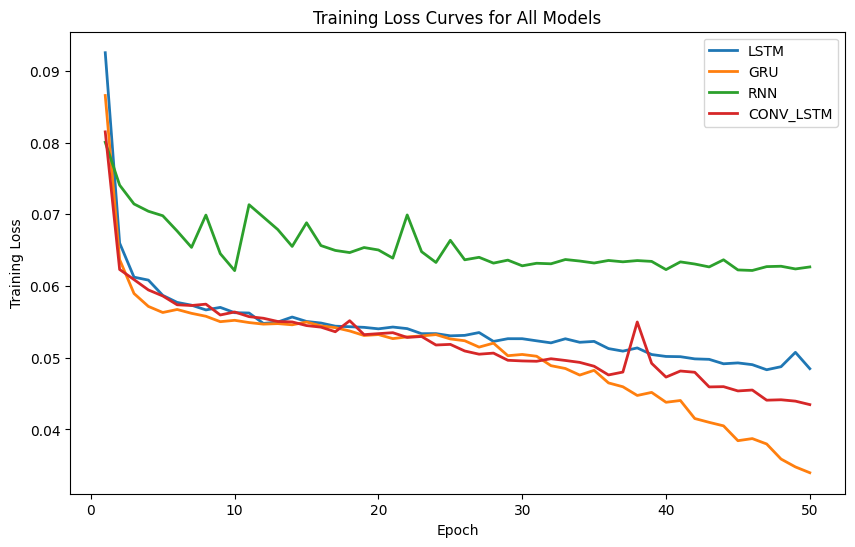

In [ ]:
plt.figure(figsize=(10, 6))

for model_name, losses in history.items():
    plt.plot(range(1, len(losses) + 1), losses, label=model_name.upper(), linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Curves for All Models')
plt.legend()
plt.grid(False)
plt.savefig("training_loss_curves.png")
plt.show()

In [ ]:
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32) if not torch.is_tensor(X_test) else X_test
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32) if not torch.is_tensor(y_test) else y_test

        X_test_tensor = X_test_tensor.to(DEVICE)
        y_test_tensor = y_test_tensor.to(DEVICE)

        preds = model(X_test_tensor)

        if preds.shape != y_test_tensor.shape:
            y_test_tensor = y_test_tensor.view_as(preds)

        mae = torch.mean(torch.abs(preds - y_test_tensor)).item()
        rmse = torch.sqrt(torch.mean((preds - y_test_tensor)**2)).item()

        return mae, rmse

lstm_mae, lstm_rmse = evaluate_model(LSTM_model, X_test, y_test)
gru_mae, gru_rmse   = evaluate_model(GRU_model, X_test, y_test)
rnn_mae, rnn_rmse   = evaluate_model(RNN_model, X_test, y_test)
conv_mae, conv_rmse   = evaluate_model(Conv_LSTM_model, X_test, y_test)

print(f"LSTM - Test MAE: {lstm_mae:.4f}, Test RMSE: {lstm_rmse:.4f}")
print(f"GRU  - Test MAE: {gru_mae:.4f}, Test RMSE: {gru_rmse:.4f}")
print(f"RNN  - Test MAE: {rnn_mae:.4f}, Test RMSE: {rnn_rmse:.4f}")
print(f"CONV_LSTM - Test MAE: {conv_mae:.4f}, Test RMSE: {conv_rmse:.4f}")

LSTM - Test MAE: 0.0419, Test RMSE: 0.0615
GRU  - Test MAE: 0.0430, Test RMSE: 0.0614
RNN  - Test MAE: 0.0450, Test RMSE: 0.0640
CONV_LSTM - Test MAE: 0.0500, Test RMSE: 0.0768


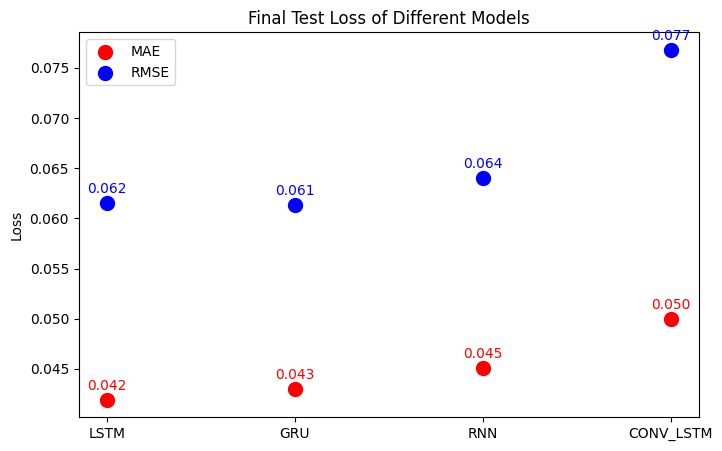

In [ ]:
models = ['LSTM', 'GRU', 'RNN', 'CONV_LSTM']
mae_values = [lstm_mae, gru_mae, rnn_mae, conv_mae]
rmse_values = [lstm_rmse, gru_rmse, rnn_rmse, conv_rmse]

plt.figure(figsize=(8, 5))

plt.scatter(models, mae_values, color='red', s=100, label='MAE')
for i, val in enumerate(mae_values):
    plt.text(models[i], val + 0.001, f"{val:.3f}", ha='center', color='red')

plt.scatter(models, rmse_values, color='blue', s=100, label='RMSE')
for i, val in enumerate(rmse_values):
    plt.text(models[i], val + 0.001, f"{val:.3f}", ha='center', color='blue')

plt.title('Final Test Loss of Different Models')
plt.ylabel('Loss')
plt.grid(False)
plt.legend()
plt.savefig("final_loss_curves.png")
plt.show()
